In [102]:
import os
import sys
import csv
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')


# for better visualization
sns.set(style="whitegrid")

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\18707\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\18707\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
# load the data
raw_data = pd.read_csv('responses.csv')
display(raw_data.head())

,Timestamp,"By selecting the ""I agree"" button option, you indicate that you have read the information provided above, that you voluntarily agree to participate in this study, and that you are at least 18 years of age.",What is your field of study?,"If you are pursuing an undergraduate degree, what year are you in? If you are pursuing graduate degree (including dual degree students) what is the degree you are pursuing? If you are a faculty, what is your position? \n\n(Please utilize ""Other..."" option and enter accordingly if there are no available options below or you are not clear about the options or you believe the options may not accurately reflect your response)",How would you rate your familiarity with LLMs?,How well do you trust LLM's?,"If you have any experience working with/using LLM, please list/describe any of them.","In what area do you think LLMs will be most used in the future? (e.g., education, healthcare, entertainment, programming, content generation, law etc.)",What specific tasks or functions do you envision LLMs being used for in that area in the future (other than those mentioned above)?,"Given your academic/professional background, what security vulnerabilities or privacy risks do you think might arise from the increased reliance on LLMs in everyday tasks and interactions in your field",...,Your Email,Are you willing to participate in 10 minutes virtual or in-person follow-up interview?,Your Name,What days and times are you free this week or next week?,"What is your field of study/major/profession?\n\n(Please utilize ""Other..."" option and enter accordingly if there are no available options below or you are not clear about the options or you believe the options may not accurately reflect your response)",vulnerable_encoding,tasks_encoding_positive_tasks,tasks_encoding_exploitative_tasks,tasks_encoding_effects,risks_encoding
0,3/25/2024 10:23:40,I agree,Engineering,Senior,5,3,utilizing ChatGPT， image generation service,healthcare,perform diagnosis and interact with patient,"untrustworthy information generation (code, fa...",...,NaN,No,NaN,NaN,NaN,"Software Development, Customer Service","Patient Diagnosis, Patient Interaction Analysis","Phishing, Spamming, Impersonation","Phishing, Spamming, Impersonation",NaN
1,3/25/2024 10:46:08,I agree,Engineering,Professor,10,1,Use them to understand LLMs so that I can carr...,Almost all aspects of life,Almost all aspects of life,A lot,...,umar.iqbal@wustl.edu,Yes,Umar Iqbal,Monday 12:30 to 1:30 or after class,NaN,NaN,All,A lot,A lot,NaN
2,3/25/2024 14:04:38,I agree,Arts and Science,Sophomore,3,5,"chatGPT, google translate",healthcare,"analyzing and communicating patient feedback,",people's private information being shared afte...,...,h.l.woodhouse@wustl.edu,Yes,Hannah Woodhouse,"Wednesday, Friday after 2:00, Tuesday Thursday...",NaN,Healthcare,Patient Interaction,Scamming,Scam calls,NaN
3,3/25/2024 14:24:00,I agree,Engineering,Junior,1,3,"Rare use of ChatGPT, frequent use of Google Tr...",Programming,"Debugging code, providing sample programs.",Negligence to verify sources of information\nU...,...,m.takato@wustl.edu,No,NaN,NaN,NaN,Education,Debugging Code,Scamming,"Usage of Unverfied sources, Data Harvesting, D...",NaN
4,3/26/2024 12:12:45,I agree,Engineering,Masters/Dual Degree,7,5,"I use a smart speaker at home, and ChatGPT eve...",I think healthcare will be a major area in whi...,I think they could be good for people who don'...,I think too much dependence on LLMs will lead ...,...,haffnerriley@wustl.edu,No,NaN,NaN,NaN,Marketing,Telehealth,"Hacking, Attacking other Models",Insecure code generation,NaN


In [104]:
# rename raw_data columns
new_columns = ['timestamp', 'field_of_study', 'education', 'familiarity', 'initial_trust', 'experience', 'future_area', 'future_tasks', 'reliance_risk', 'possible_exploitation', 'privacy_concern', 'other_risks', 'vulnerable_sector', 'interdisciplinary', 'fingerprint', 'comprehension_concern', 'final_trust', 'what_is','vulnerable_encoding', 'positive_tasks_encoding', 
    'exploitative_tasks_encoding', 'effects_encoding', 'risks_encoding'
]
# drop columns that are not needed
columns_to_drop = ['By selecting the "I agree" button option, you indicate that you have read the information provided above, that you voluntarily agree to participate in this study, and that you are at least 18 years of age.', 
                   'Your Email',
                   'Are you willing to participate in 10 minutes virtual or in-person follow-up interview?', 
                   'Your Name',
                   'What days and times are you free this week or next week?'
                   ]
pp_data = raw_data.drop(columns=columns_to_drop)

# # rename columns
pp_data.columns = new_columns
pp_data = pp_data.drop(columns=['what_is'])

# Standardize text: convert all to lower case
pp_data['field_of_study'] = pp_data['field_of_study'].str.lower()

# Trim whitespace
pp_data['field_of_study'] = pp_data['field_of_study'].str.strip()

# Correct common misspellings manually (could be automated with a mapping or more sophisticated methods)
misspellings = {'pyschology': 'psychology'}
pp_data['field_of_study'] = pp_data['field_of_study'].replace(misspellings)

unique_fields = pp_data['field_of_study'].value_counts()
print("Unique Fields of Study and Their Counts:")
print(unique_fields)

Unique Fields of Study and Their Counts:
field_of_study
arts and science               41
engineering                    17
business                        7
computer science                4
nursing                         2
psychology                      2
chemistry                       1
legal (practicing attorney)     1
Name: count, dtype: int64


# Data Analysis

In [105]:
# Descriptive statistics
print("Descriptive Statistics:")
print(pp_data [['familiarity', 'initial_trust', 'final_trust']].describe())

# Calculating mode (note: mode could be multi-modal)
print("\nMode:")
print(pp_data [['familiarity', 'initial_trust', 'final_trust']].mode().head(1))



Descriptive Statistics:
       familiarity  initial_trust  final_trust
count    75.000000      75.000000    75.000000
mean      4.240000       4.853333     3.986667
std       2.335623       2.018116     2.010065
min       1.000000       1.000000     1.000000
25%       2.000000       3.000000     3.000000
50%       5.000000       5.000000     4.000000
75%       6.000000       6.000000     5.000000
max      10.000000      10.000000    10.000000

Mode:
   familiarity  initial_trust  final_trust
0          5.0            5.0            3


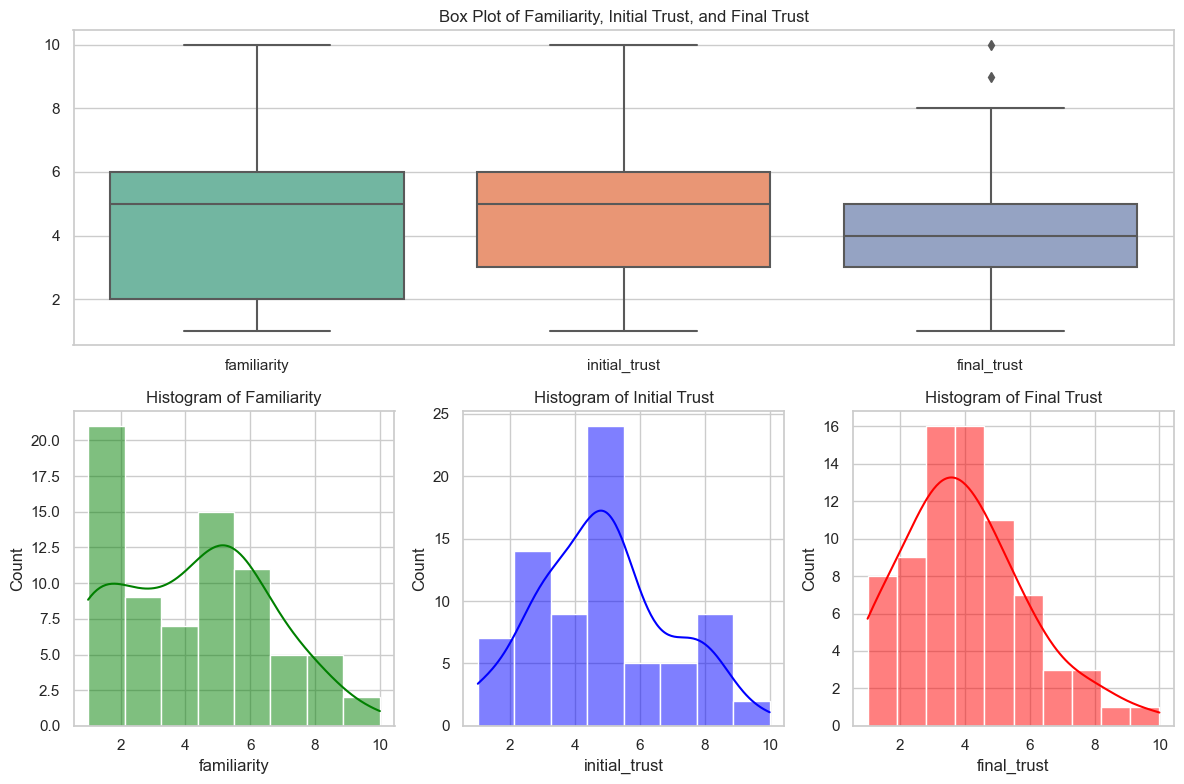

In [123]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Data
data = pp_data[['familiarity', 'initial_trust', 'final_trust']]

# Create a figure for the plots
plt.figure(figsize=(12, 8))

# Create a subplot for the box plot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
sns.boxplot(data=data, palette="Set2")
plt.title('Box Plot of Familiarity, Initial Trust, and Final Trust')

# Create subplots for histograms
plt.subplot(2, 3, 4)  # 2 rows, 3 columns, 4th subplot
sns.histplot(data['familiarity'], kde=True, color="green")
plt.title('Histogram of Familiarity')

plt.subplot(2, 3, 5)  # 5th subplot
sns.histplot(data['initial_trust'], kde=True, color="blue")
plt.title('Histogram of Initial Trust')

plt.subplot(2, 3, 6)  # 6th subplot
sns.histplot(data['final_trust'], kde=True, color="red")
plt.title('Histogram of Final Trust')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## Simple linear regression analysis to explore relationships between variables familiarity with LLMs and initial trust levels.

In [106]:
import statsmodels.api as sm

# Simple linear regression
X = sm.add_constant(pp_data['familiarity'])  # adding a constant
Y = pp_data['initial_trust']

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

# Print out the statistics
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          initial_trust   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5310
Date:                Tue, 16 Apr 2024   Prob (F-statistic):              0.469
Time:                        14:16:45   Log-Likelihood:                -158.31
No. Observations:                  75   AIC:                             320.6
Df Residuals:                      73   BIC:                             325.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5420      0.487      9.326      

### Response Analysis

From the OLS regression results, we can gather several insights:

1. **R-squared**: The R-squared value is 0.013, which indicates that only about 1.3% of the variation in initial trust levels is explained by the variation in familiarity with LLMs. This suggests that familiarity with LLMs alone does not strongly predict initial trust levels.

2. **Coefficient Estimates**: The coefficient for the variable "familiarity" is 0.0989. This suggests that for every one-unit increase in familiarity with LLMs, initial trust levels increase by approximately 0.0989 units. However, since the coefficient is not statistically significant (p-value = 0.324), we cannot conclude that this relationship is not likely due to random chance.

3. **Intercept**: The intercept (const) is 4.4704. This represents the estimated initial trust level when familiarity with LLMs is zero.

4. **Statistical Significance**: The p-values associated with the coefficient estimates provide information about their statistical significance. In this case, the p-value for the coefficient of "familiarity" is 0.324, which is greater than the typical significance level of 0.05. This suggests that familiarity with LLMs is not a statistically significant predictor of initial trust levels in this model.

5. **Model Fit**: The F-statistic is 0.9850 with a associated probability of 0.324. This suggests that the overall fit of the model is not statistically significant, further indicating that familiarity with LLMs alone may not be a strong predictor of initial trust levels.

6. **Assumptions**: The assumptions of linear regression (e.g., normality of residuals, homoscedasticity) should be assessed to ensure the validity of the model results.

In summary, based on these results, familiarity with LLMs does not appear to be a significant predictor of initial trust levels. Additional factors or a more complex model may be needed to better understand the determinants of initial trust in LLMs.

## Classify Responses and create distribution table 

In [124]:
def preprocess_text(text):
    # Check if text is not a string or if it is NaN
    if not isinstance(text, str):
        return []
    
    # Tokenize text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and non-alphabetic words
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    return tokens



In [125]:
categories_use_area = {
    'education': [
        'education','educate', 'lesson', 'learning', 'teaching', 'school', 'university', 'students', 'homework', 'learn', 'essay', 'essays'
        'academic', 'tutors', 'study', 'knowledge', 'search engine', 'answers', 'assignments', 'personalized tutors'
    ],
    'healthcare': [
        'healthcare', 'health', 'medical', 'medicine', 'diagnosis', 'clinical', 'physicians',
        'patient', 'diagnostics', 'treatment', 'clinical experience'
    ],
    'entertainment': [
        'entertainment', 'movies', 'films', 'media', 'gaming', 'game', 'video games',
        'acting', 'video', 'music', 'performances', 'creative'
    ],
    'programming': [
        'programming', 'software', 'coding', 'code', 'developer',
        'debugging', 'programmers', 'technical', 'technology', 'tech', 'coding', 'innovation', 'search engines', 'information technology',
        'data management'
    ],
    'content_generation': [
        'content', 'generation', 'writing', 'articles', 'news', 'reporting', 'blogs',
        'content creation', 'business writing', 'text generation', 'document creation', 'media creation'
    ],
    'law': [
        'law', 'legal', 'policy', 'regulations', 'compliance', 'precedent', 'legal research'
    ],
    'business': [
        'business', 'corporate', 'finance', 'marketing', 'customer service', 'business plan',
        'management', 'strategy', 'operations', 'scheduling'
    ],
    'research': [
        'research', 'scientific', 'studies', 'data analysis', 'experimentation',
        'science', 'scientific research', 'data gathering', 'analysis', 'material science'
    ],
    'other': []  
}



In [126]:
# Function to classify responses based on keywords
def classify_response(text, categories):
    processed_text = preprocess_text(text)
    response_categories = []
    for category, keywords in categories.items():
        # Ensure 'other' is not treated as a keyword category
        if category == 'other':
            continue
        for keyword in keywords:
            if keyword in processed_text:
                response_categories.append(category)
                break  # Stop after the first match to prevent multiple entries of the same category
    
    # Check if no categories were matched, and if so, assign to 'other'
    if not response_categories:
        response_categories.append('other')
    
    return list(set(response_categories))  # Return unique categories

# Assuming 'categories_use_area' includes an 'other' key
# Make sure 'other' exists in your category dictionary
categories_use_area['other'] = []

# Apply classification
pp_data['area_classified'] = pp_data['future_area'].apply(lambda x: classify_response(x, categories_use_area))


# Display the results
print(pp_data[['area_classified']].head())

  area_classified
0    [healthcare]
1         [other]
2    [healthcare]
3   [programming]
4    [healthcare]


In [127]:
def summarize_categories(column, data):
    category_counts = Counter()
    total_responses = 0  # To count total non-empty responses

    for categories in data[column]:
        if categories:  # Check if the list is not empty
            category_counts.update(categories)
            total_responses += 1

    # Creating a DataFrame from the counts
    category_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])
    
    # Calculate the percentage of participants for each category
    category_df['Percent'] = (category_df['Count'] / total_responses) * 100
    
    return category_df

category_table1 = summarize_categories('area_classified', pp_data)
def style_table(df):
    return df.style\
             .set_properties(**{'text-align': 'left'})\
             .set_table_styles([
                 {'selector': 'th', 'props': [('text-align', 'left')]},  # Ensures headers are left-aligned
                 {'selector': 'tr', 'props': [('background-color', '')]}  # Resets any row background color styling
             ])\
             .set_caption("Distribution of Area")

print("Distribution of area:")
styled_table1 = style_table(category_table1)
display(styled_table1)


Distribution of area:


,Category,Count,Percent
0,healthcare,16,21.333333
1,other,13,17.333333
2,programming,24,32.000000
3,entertainment,11,14.666667
4,law,5,6.666667
5,education,23,30.666667
6,content_generation,19,25.333333
7,research,6,8.000000
8,business,5,6.666667


                  Category  Frequency
2               healthcare         10
3                education          9
13  arts and entertainment          9
0     software development          8
14              journalism          5
6                    other          3
15                politics          3
4                marketing          2
7             data science          2
1         customer service          2
10                 finance          2
11              government          2
17                   media          1
16           advertisement          1
9            cybersecurity          1
12               insurance          1
8         criminal justice          1
5                 military          1
18                 fashion          1


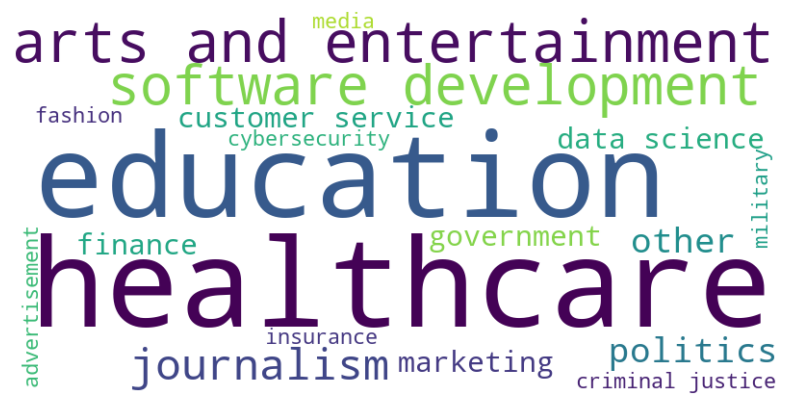

In [129]:
# 'vulnerable_encoding', 'positive_tasks_encoding', 
#     'exploitative_tasks_encoding', 'effects_encoding', 'risks_encoding'
# Splitting comma-separated entries and counting
category_counter = Counter()

def preprocess(text):
    if pd.isna(text) or text.strip() == "":
        return None  # Return None to indicate invalid or empty entry
    text = text.strip().lower()
    replacements = {
        'data science': 'data science', 'data sciences': 'data science',
        'customer service': 'customer service', 'customers service': 'customer service',
        'software development': 'software development', 'software dev': 'software development', 'software developmentelopment': 'software development',
        'arts and entertainment': 'arts and entertainment', 'art and entertainment': 'arts and entertainment',
        'healthcare': 'healthcare', 'health care': 'healthcare'
    }
    for key, value in replacements.items():
        text = text.replace(key, value)
    return text

# Splitting comma-separated entries and counting
category_counter = Counter()
for entry in pp_data['vulnerable_encoding']:
    if pd.notna(entry):  # Only process if entry is not NaN
        categories = entry.split(',')
        categories = [preprocess(cat) for cat in categories if preprocess(cat)]
        category_counter.update(categories)

# Converting counter to DataFrame for display
category_df = pd.DataFrame(category_counter.items(), columns=['Category', 'Frequency'])
category_df = category_df.sort_values(by='Frequency', ascending=False)
print(category_df)

# Optionally, you can generate a word cloud to visualize the frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_counter)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [131]:
# Define main categories and their corresponding detailed categories
import pandas as pd

# Predefined category classifications
vulnerable_sectors_class = {
    'healthcare': ['healthcare'],
    'education': ['education'],
    'technology': ['software development', 'data science', 'cybersecurity'],
    'arts and media': ['arts and entertainment', 'journalism', 'media'],
    'government and public service': ['government', 'military', 'public service'],
    'business and marketing': ['marketing', 'customer service', 'business', 'finance', 'advertisement'],
    'other': []  # Will include categories not explicitly mapped
}

# Function to map individual categories to main categories
def map_category_to_main(cat, mapping):
    for main_category, subcats in mapping.items():
        if cat in subcats:
            return main_category
    return 'other'

# Map each category to its corresponding main category
category_df['Main Category'] = category_df['Category'].apply(lambda x: map_category_to_main(x, vulnerable_sectors_class))

# Aggregate frequencies by main categories
final_counts = category_df.groupby('Main Category').agg({
    'Frequency': 'sum',
    'Category': lambda x: ', '.join(sorted(set(x)))  # Collect unique subcategories
}).reset_index()

# Calculate total percentages
total_frequency = final_counts['Frequency'].sum()
final_counts['Percent'] = (final_counts['Frequency'] / total_frequency * 100).round(1)

# Print the final categorized DataFrame
print(final_counts)


def style_table(df, name):
    return df.style\
             .set_properties(**{'text-align': 'left'})\
             .set_table_styles([
                 {'selector': 'th', 'props': [('text-align', 'left')]},  # Ensures headers are left-aligned
                 {'selector': 'tr', 'props': [('background-color', '')]}  # Resets any row background color styling
             ])\
             .set_caption("Distribution of" + name)\
             .format({'Percent': "{:.1f}%"})  # Format percent with two decimal places

styled_table = style_table(final_counts, " vulnerable sectors")
display(styled_table)



                   Main Category  Frequency  \
0                 arts and media         15   
1         business and marketing          7   
2                      education          9   
3  government and public service          3   
4                     healthcare         10   
5                          other          9   
6                     technology         11   

                                            Category  Percent  
0          arts and entertainment, journalism, media     23.4  
1  advertisement, customer service, finance, mark...     10.9  
2                                          education     14.1  
3                               government, military      4.7  
4                                         healthcare     15.6  
5  criminal justice, fashion, insurance, other, p...     14.1  
6  cybersecurity, data science, software development     17.2  


,Main Category,Frequency,Category,Percent
0,arts and media,15,"arts and entertainment, journalism, media",23.4%
1,business and marketing,7,"advertisement, customer service, finance, marketing",10.9%
2,education,9,education,14.1%
3,government and public service,3,"government, military",4.7%
4,healthcare,10,healthcare,15.6%
5,other,9,"criminal justice, fashion, insurance, other, politics",14.1%
6,technology,11,"cybersecurity, data science, software development",17.2%


                           Category  Frequency
21                           coding         13
26            perform routine tasks          5
17                automated writing          5
2                               all          4
6                content generation          4
..                              ...        ...
30                 customer service          1
1      patient interaction analysis          1
32          news article generation          1
33                 content creation          1
61  adaptive programming assistance          1

[62 rows x 2 columns]


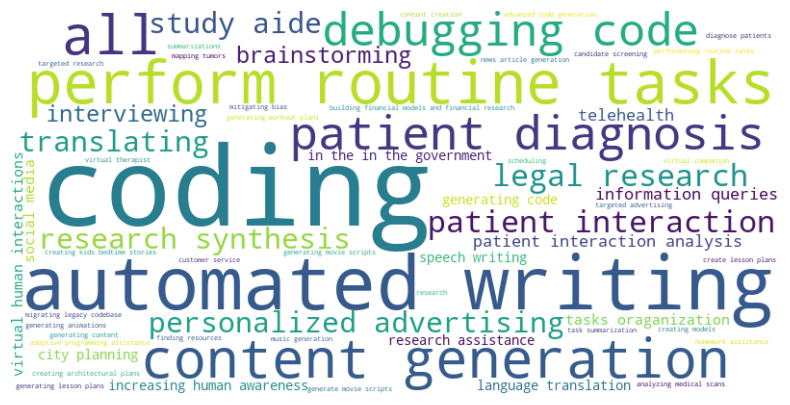

In [134]:
# 'vulnerable_encoding', 'positive_tasks_encoding', 
#     'exploitative_tasks_encoding', 'effects_encoding', 'risks_encoding'
# Splitting comma-separated entries and counting
category_counter = Counter()

def preprocess(text):
    if pd.isna(text) or text.strip() == "":
        return None  # Return None to indicate invalid or empty entry
    text = text.strip().lower()
    replacements = {
        'performe routine tasks': 'perform routine tasks',
        'tasks organization': 'task organization',
        'peform routine tasks': 'perform routine tasks',
        'fiancial models': 'financial models',  
        'government': 'in the government', 
        'writing code': 'coding', 'personalized ads': 'personalized advertising', 'personal advertising': 'personalized advertising' 
    }
    for key, value in replacements.items():
        text = text.replace(key, value)
    return text

# Splitting comma-separated entries and counting
category_counter = Counter()
for entry in pp_data['positive_tasks_encoding']:
    if pd.notna(entry):  # Only process if entry is not NaN
        categories = entry.split(',')
        categories = [preprocess(cat) for cat in categories if preprocess(cat)]
        category_counter.update(categories)

# Converting counter to DataFrame for display
category_df = pd.DataFrame(category_counter.items(), columns=['Category', 'Frequency'])
category_df = category_df.sort_values(by='Frequency', ascending=False)
print(category_df)

# Optionally, you can generate a word cloud to visualize the frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_counter)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [135]:
tasks_categories = {
    'healthcare': [
        'patient diagnosis', 'telehealth', 'diagnose patients', 'analyzing medical scans', 'virtual therapist',
        'patient interaction', 'patient interaction analysis', 'medical tasks'
    ],
    'software development': [
        'debugging code', 'writing code', 'generating code', 'automated writing', 'creating models', 'adaptive programming assistance',
        'code generation', 'migrating legacy codebase', 'coding', 'software tasks', 'advanced code generation'
    ],
    'research and development': [
        'research synthesis', 'research assistance', 'mapping tumors', 'targeted research', 'research', 'building financial models and financial research'
    ],
    'education and training': [
        'content generation', 'create lesson plans', 'homework assistance',
        'study aide', 'teaching', 'educational tasks', 'training tasks'
    ],
    'legal and compliance': [
        'legal research', 'legal tasks', 'compliance tasks'
    ],
    'marketing and advertising': [
        'personal advertising', 'targeted advertising', 'personalized ads', 'personalized advertising', 'marketing tasks', 
    ],
    'public service and governance': [
        'city planning', 'in the government', 'public governance', 'government tasks'
    ],
    'content generation': [
        'generating animations',  'content generation','content creation', 'generating content', 'music generation',
        'generate movie scripts', 'creating architectural plans', 'creative tasks'
        'automated writing', 'news article generation', 'speech writing', 'translating','language translation' 'creating kids bedtime stories', 'generating lesson plans', 'generating movie scripts', 'generating workout plans','generating content', 'content creation', 'generate movie scripts', 'generating animations', 'creating architectural plans'
    ],
    'administrative tasks':['building financial models and financial research, candidate screening, customer service','summarizations', 'scheduling', 'task summarization', 'tasks oraganization', 'perform routine tasks', 'performoning routine tasks'],
    'other': []
    
}

# Map each category to its corresponding main category
category_df['Main Category'] = category_df['Category'].apply(lambda x: map_category_to_main(x, tasks_categories))

# Aggregate frequencies by main categories
final_counts = category_df.groupby('Main Category').agg({
    'Frequency': 'sum',
    'Category': lambda x: ', '.join(sorted(set(x)))  # Collect unique subcategories
}).reset_index()

# Calculate total percentages
total_frequency = final_counts['Frequency'].sum()
final_counts['Percent'] = (final_counts['Frequency'] / total_frequency * 100).round(2)

# Print the final categorized DataFrame
# print(final_counts)

styled_table = style_table(final_counts, " future llm tasks ")
display(styled_table)



,Main Category,Frequency,Category,Percent
0,administrative tasks,10,"perform routine tasks, performoning routine tasks, scheduling, summarizations, task summarization, tasks oraganization",10.0%
1,content generation,13,"content creation, creating architectural plans, generate movie scripts, generating animations, generating content, generating lesson plans, generating movie scripts, generating workout plans, music generation, news article generation, speech writing, translating",13.0%
2,education and training,8,"content generation, create lesson plans, homework assistance, study aide",8.0%
3,healthcare,10,"analyzing medical scans, diagnose patients, patient diagnosis, patient interaction, patient interaction analysis, telehealth, virtual therapist",10.0%
4,legal and compliance,2,legal research,2.0%
5,marketing and advertising,3,"personalized advertising, targeted advertising",3.0%
6,other,20,"all, brainstorming, candidate screening, creating kids bedtime stories, customer service, finding resources, in the in the government, increasing human awareness, information queries, interviewing, language translation, mitigating bias, social media, virtual companion, virtual human interactions",20.0%
7,public service and governance,1,city planning,1.0%
8,research and development,7,"building financial models and financial research, mapping tumors, research, research assistance, research synthesis, targeted research",7.0%
9,software development,26,"adaptive programming assistance, advanced code generation, automated writing, coding, creating models, debugging code, generating code, migrating legacy codebase",26.0%


                                  Category  Frequency
4                                 scamming         15
10                              deep fakes         13
2                            impersonating          8
8                           misinformation          8
0                                 phishing          5
11                political disinformation          5
15                         data harvesting          5
13              psychological manipulation          5
17                              plagiarism          3
14           generating crime instructions          3
1                                 spamming          2
16                               forgeries          2
5                                  hacking          2
12  unauthorized access to medical records          1
23                              catfishing          1
30                      exploit loneliness          1
29                           data breaches          1
28                     artic

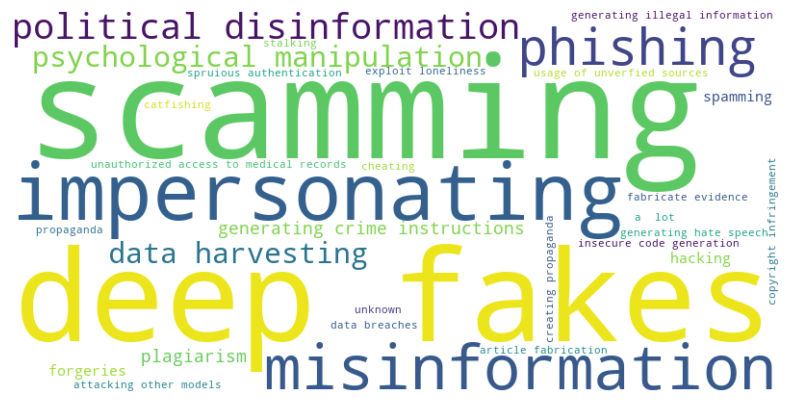

In [136]:
def preprocess(text):
    if pd.isna(text) or text.strip() == "":
        return None  # Return None to indicate invalid or empty entry
    text = text.strip().lower()
    replacements = {
        'deep fakea': 'deep fakes', 'deep fake': 'deep fakes', 'deep fakes': 'deep fakes', 'deep fakess': 'deep fakes', 'creating deep fakes': 'deep fakes',
        'cat fishing': 'catfishing', 'data harversting': 'data harvesting', 'data harverst': 'data harvesting', 'creating propaganda':'propaganda', 'generating propaganda':'propaganda','generate propaganda':'propaganda',
        'physcological manipulation': 'psychological manipulation', 'creatting': 'creating', 'creating': 'creating', 'creating misinformation': 'misinformation',
        'scaming': 'scamming', 'scamming': 'scamming', 'plaigarism': 'plagiarism', 'impersonation': 'impersonating', 'generate': 'generating'
    }
    for key, value in replacements.items():
        text = text.replace(key, value)
    return text

# Splitting comma-separated entries and counting
category_counter = Counter()
for entry in pp_data['exploitative_tasks_encoding']:
    if pd.notna(entry):  # Only process if entry is not NaN
        categories = entry.split(',')
        categories = [preprocess(cat) for cat in categories if preprocess(cat)]
        category_counter.update(categories)

# Converting counter to DataFrame for display
category_df = pd.DataFrame(category_counter.items(), columns=['Category', 'Frequency'])
category_df = category_df.sort_values(by='Frequency', ascending=False)
print(category_df)
# Example using pandas
print(category_df.describe())

# Optionally, you can generate a word cloud to visualize the frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_counter)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

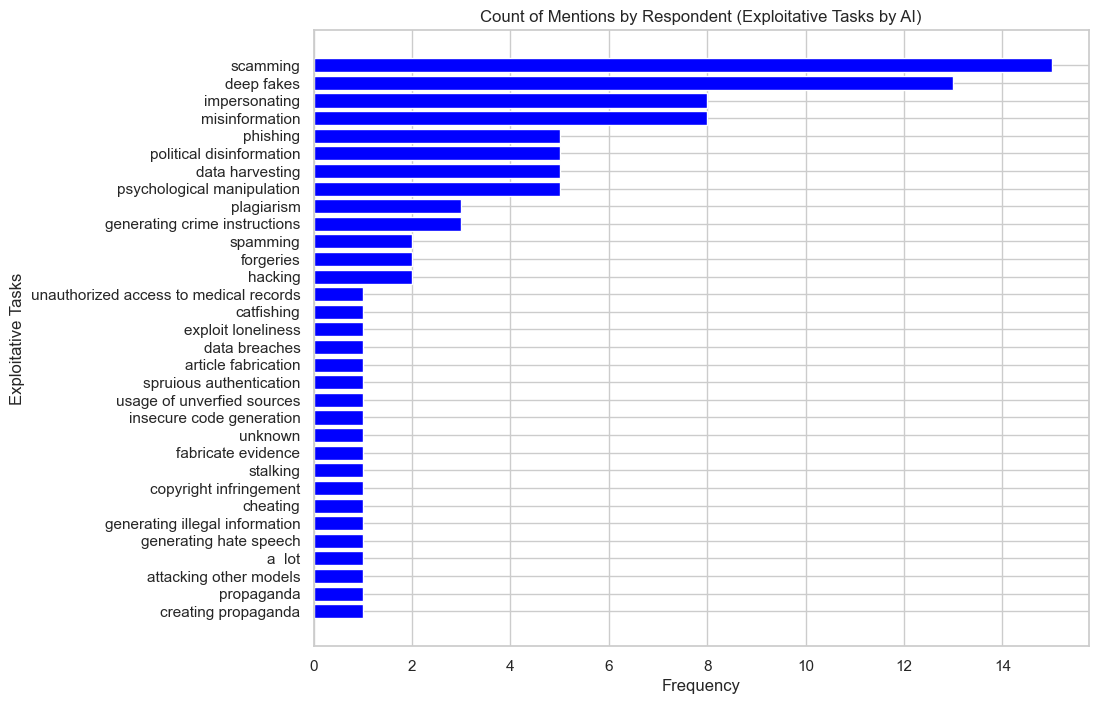

In [140]:
# Sort data for better visualization
plt.figure(figsize=(10, 8))
plt.barh(category_df['Category'],category_df['Frequency'], color='blue')
plt.xlabel('Frequency')
plt.ylabel('Exploitative Tasks')
plt.title('Count of Mentions by Respondent (Exploitative Tasks by AI)')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values at the top
plt.show()


In [117]:
trust_by_field = pp_data.groupby('field_of_study')['initial_trust'].mean()

trust_by_field_df = trust_by_field.reset_index()

trust_by_field_df = trust_by_field_df.sort_values(by='initial_trust', ascending=False)

print(trust_by_field_df)


                field_of_study  initial_trust
1                     business       5.571429
5  legal (practicing attorney)       5.000000
0             arts and science       4.951220
4                  engineering       4.882353
3             computer science       4.250000
6                      nursing       4.000000
7                   psychology       4.000000
2                    chemistry       1.000000


In [118]:
# Assuming your DataFrame is named pp_Data and is already loaded

# Group data by 'field_of_study' and calculate the mean of 'initial_trust' and count of participants
trust_and_count_by_field = pp_data.groupby('field_of_study')['initial_trust'].agg(['mean', 'count'])

# Rename the columns for clarity
trust_and_count_by_field.rename(columns={'mean': 'Mean Initial Trust', 'count': 'Count of Participants'}, inplace=True)

# Reset index to make 'field_of_study' a column again
trust_and_count_by_field = trust_and_count_by_field.reset_index()

# Sort the DataFrame by 'Mean Initial Trust' to see which fields have higher trust
trust_and_count_by_field = trust_and_count_by_field.sort_values(by='Mean Initial Trust', ascending=False)

# Display the DataFrame
print(trust_and_count_by_field)



                field_of_study  Mean Initial Trust  Count of Participants
1                     business            5.571429                      7
5  legal (practicing attorney)            5.000000                      1
0             arts and science            4.951220                     41
4                  engineering            4.882353                     17
3             computer science            4.250000                      4
6                      nursing            4.000000                      2
7                   psychology            4.000000                      2
2                    chemistry            1.000000                      1


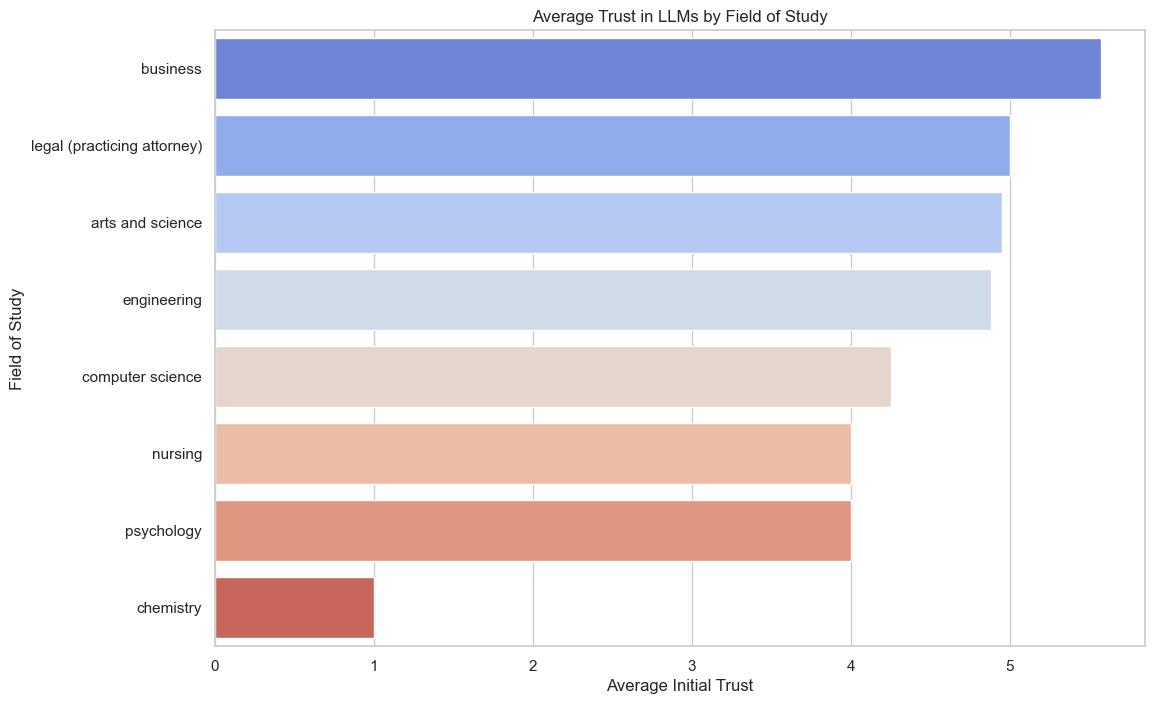

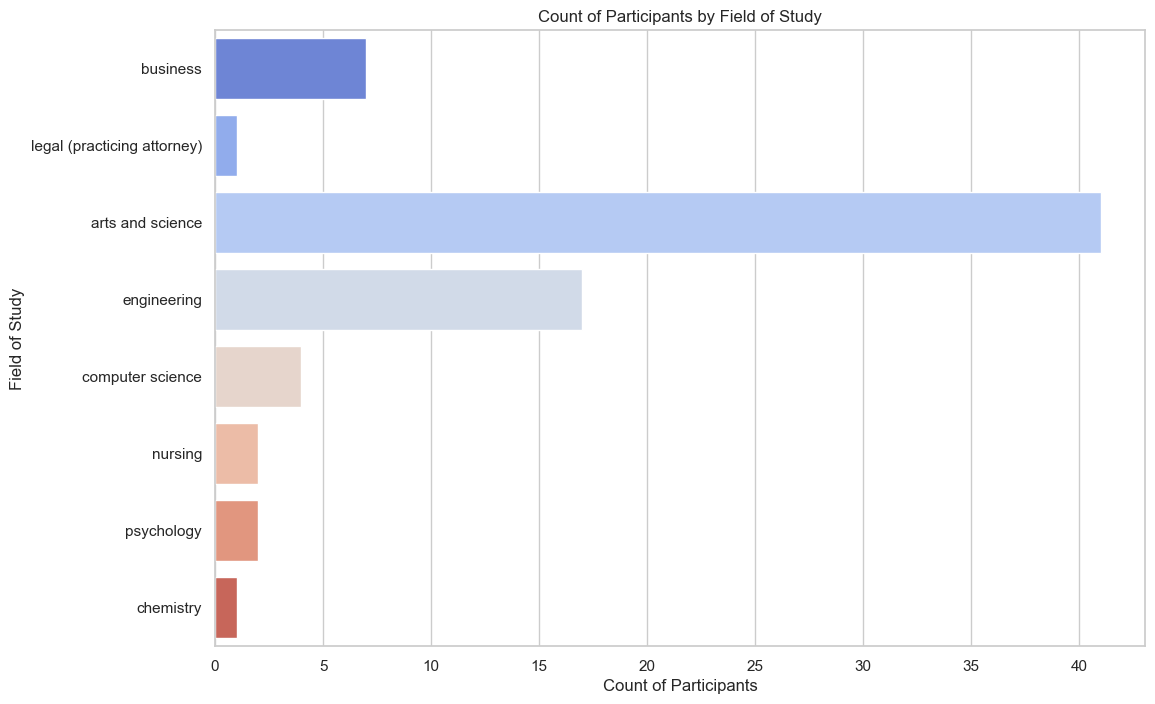

In [119]:
# Create a bar plot for the mean trust
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Mean Initial Trust', y='field_of_study', data=trust_and_count_by_field, palette="coolwarm")
plt.title('Average Trust in LLMs by Field of Study')
plt.xlabel('Average Initial Trust')
plt.ylabel('Field of Study')

# Optionally, create a second plot for participant count
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Count of Participants', y='field_of_study', data=trust_and_count_by_field, palette="coolwarm")
plt.title('Count of Participants by Field of Study')
plt.xlabel('Count of Participants')
plt.ylabel('Field of Study')

# Show the plots
plt.show()


In [120]:
# Assuming your DataFrame is named pp_Data and is already loaded

# Group data by 'field_of_study' and calculate the mean of 'initial_trust' and count of participants
trust_and_count_by_field2 = pp_data.groupby('field_of_study')['final_trust'].agg(['mean', 'count'])

# Rename the columns for clarity
trust_and_count_by_field2.rename(columns={'mean': 'Mean final Trust', 'count': 'Count of Participants'}, inplace=True)

# Reset index to make 'field_of_study' a column again
trust_and_count_by_field2 = trust_and_count_by_field2.reset_index()

# Sort the DataFrame by 'Mean Initial Trust' to see which fields have higher trust
trust_and_count_by_field2 = trust_and_count_by_field2.sort_values(by='Mean final Trust', ascending=False)

# Display the DataFrame
print(trust_and_count_by_field2)

                field_of_study  Mean final Trust  Count of Participants
1                     business          5.000000                      7
5  legal (practicing attorney)          5.000000                      1
0             arts and science          4.121951                     41
4                  engineering          3.941176                     17
3             computer science          3.250000                      4
7                   psychology          3.000000                      2
6                      nursing          1.500000                      2
2                    chemistry          1.000000                      1


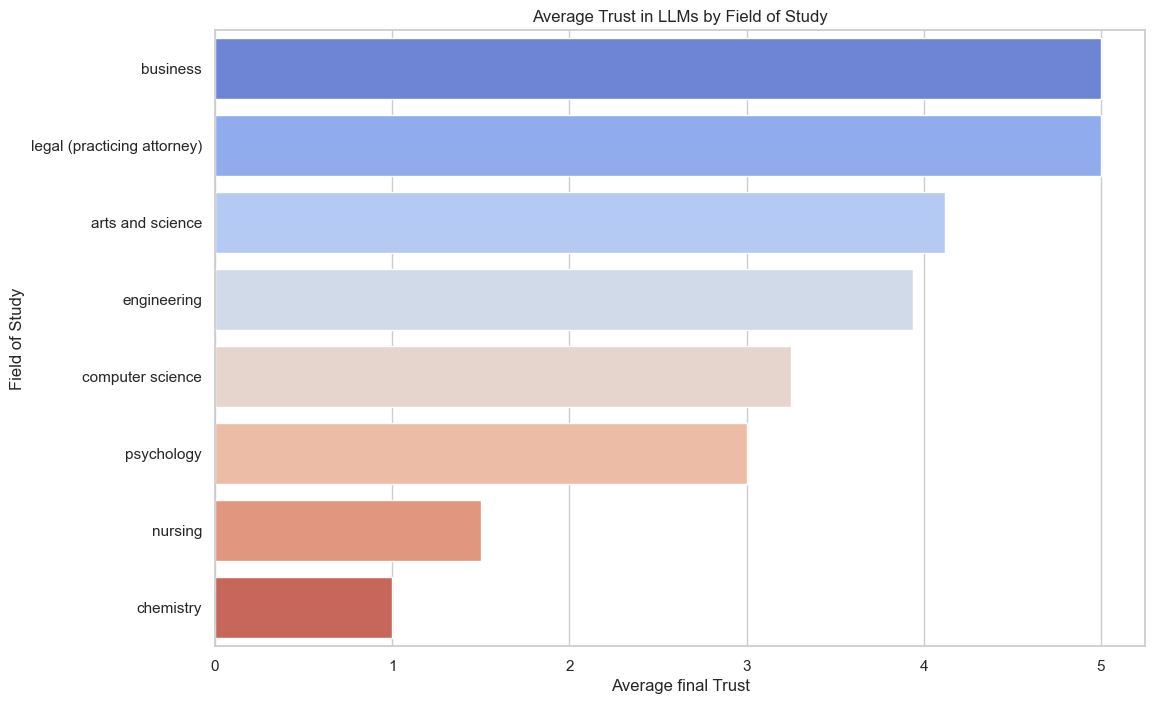

In [121]:
# Create a bar plot for the mean trust
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Mean final Trust', y='field_of_study', data=trust_and_count_by_field2, palette="coolwarm")
plt.title('Average Trust in LLMs by Field of Study')
plt.xlabel('Average final Trust')
plt.ylabel('Field of Study')

# Show the plots
plt.show()

In [122]:
# Calculate the average of the 'initial_trust' column
average_trust = pp_data['initial_trust'].mean()

# Print the average trust score
print("Average Intial Trust:", average_trust)

# Calculate the average of the 'initial_trust' column
average_trust = pp_data['final_trust'].mean()

# Print the average trust score
print("Average Final Trust:", average_trust)

Average Intial Trust: 4.8533333333333335
Average Final Trust: 3.986666666666667
